In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy import signal
from tempfile import TemporaryFile

/home/jg2364/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jg2364/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jg2364/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


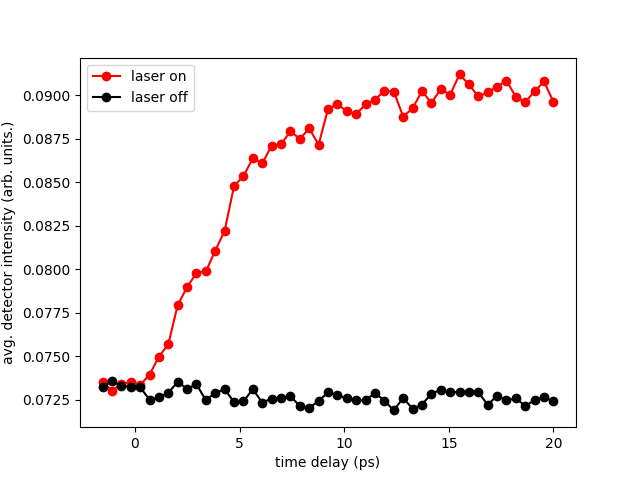

In [2]:
%matplotlib notebook

### extract arrays from HDF5 file from measurement. ~30000 detector shots/images per file 
f = h5py.File('/data3/2021/2021_3_LCLS_LAO/smalldata/xpplv7918_Run0034.h5','r') ## Open Measurement HDF5
ipm2 = np.array(f['ipm2/sum'])## Intensity sum of each shot
detec = np.array(f['jungfrau1M/ROIw_0_area'])## Detector image for each shot
xOn = np.array(f['lightStatus/xray']) ## X-ray On Boolean for each shot
laserOn = np.array(f['lightStatus/laser']) ## Laser On Boolean for each shot
timeDelay = np.array(f['scan/lxt_ttc'])*1e12  ## time delay between X-ray and Laser Pulse

thresh = 20.0### set the threshold, only take shots/images higher than this
detec_roi = detec[:,107:127, 69:89]### area where the X-ray feature is. 

#### sort the shots, for laser X-ray on, Laser ON, and Threshold
ind_on = np.where(np.logical_and(np.logical_and(xOn==1, laserOn==1), ipm2>thresh))
detec_on = detec_roi[ind_on]
delays_on = timeDelay[ind_on]
ipm_on = ipm2[ind_on]

#### sort the shots, for laser X-ray on, Laser OFF, and Threshold
ind_off = np.where(np.logical_and(np.logical_and(xOn==1, laserOn==0), ipm2>thresh))
detec_off = detec_roi[ind_off]
delays_off = timeDelay[ind_off]
ipm_off = ipm2[ind_off]

### Set time delay array, known a priori from experiment
tau = np.linspace(delays_on[0], delays_on[-1], 50)

## initialize arrays
totalArray_on = np.zeros((len(tau), detec_on.shape[1], detec_on.shape[2]))
meanArray_on = np.zeros(len(tau))

totalArray_off = np.zeros((len(tau), detec_off.shape[1], detec_off.shape[2]))
meanArray_off = np.zeros(len(tau))

## normalize the images to a shot intensity, and then bin the shots and average over the bin
for index in range(len(totalArray_on)):
    avg_ipm_on = np.mean(ipm_on[np.where(np.digitize(delays_on, bins = tau) == index)])
    meanArray_on[index] = np.mean(detec_on[np.where(np.digitize(delays_on, bins = tau) == index)])/avg_ipm_on
    
for index in range(len(totalArray_off)):
    avg_ipm_off = np.mean(ipm_off[np.where(np.digitize(delays_off, bins = tau) == index)])
    meanArray_off[index] = np.mean(detec_off[np.where(np.digitize(delays_off, bins = tau) == index)])/avg_ipm_off

plt.plot(tau, meanArray_on, '-o', color='red', label='laser on')
plt.plot(tau, meanArray_off, '-o', color='black', label='laser off')
plt.xlabel("time delay (ps)")
plt.ylabel("avg. detector intensity (arb. units.)")
plt.legend()